In [10]:
import warnings

import pandas as pd
import numpy as np
from xgboost import XGBClassifier

from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay,RocCurveDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt

from shap import TreeExplainer

warnings.filterwarnings('ignore')

In [ ]:
params = {'bagging_temperature': 0.8438108460844879,
          'depth': 10,
          'l2_leaf_reg': 2.9338790735090807,
          'learning_rate': 0.02415662243440924,
          'rsm': 0.8956264989725725}

cat_tune = CatBoostClassifier(random_seed=42, iterations=200, early_stopping_rounds=75, eval_metric='F1', verbose=0)
cat_tune.fit(X_train, y_train,eval_set=[(X_val, y_val)],use_best_model=True,cat_features=cat_cols,verbose=0)



In [12]:
def evaluate_model(X_train, X_val, y_train, y_val):
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        use_best_model=True,
        cat_features=cat_cols,
        verbose=0
    )

    y_pred = model.predict(X_val)

    return f1_score(y_val, y_pred)


def handle_nan(X_train, X_val):
    cat_cols = ['avg_home_team_rating_x_ewm_shoton_away_binned', 'average_rating_away_binned', 'average_rating_home_binned', 'ewm_possession_home_binned', 'avg_away_team_rating_binned']
    num_cols = X_train.select_dtypes(include='number').columns

    # Impute numerical columns
    imputer = IterativeImputer(initial_strategy='most_frequent', max_iter=5, n_nearest_features=4)
    X_train_num = pd.DataFrame(imputer.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
    X_val_num = pd.DataFrame(imputer.transform(X_val[num_cols]), columns=num_cols, index=X_val.index)

    # Handle categorical columns
    for column in cat_cols:
        # Add 'Missing' category
        X_train[column] = X_train[column].cat.add_categories('Missing')
        X_val[column] = X_val[column].cat.add_categories('Missing')

        # Fill NaN values with 'Missing'
        X_train[column] = X_train[column].fillna('Missing')
        X_val[column] = X_val[column].fillna('Missing')

    # Concatenate numerical and categorical dataframes
    X_train_processed = pd.concat([X_train_num, X_train[cat_cols]], axis=1)
    X_val_processed = pd.concat([X_val_num, X_val[cat_cols]], axis=1)

    return X_train_processed, X_val_processed


def individual_log_loss(y_true, y_pred, eps=1e-15):
    """Compute log-loss for each individual of the sample."""

    y_pred = np.clip(y_pred, eps, 1 - eps)
    return - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)


def shap_sum2proba(shap_sum):
    """Compute sigmoid function of the Shap sum to get predicted probability."""

    return 1 / (1 + np.exp(-shap_sum))

In [13]:
def get_preds_shaps(X_train, X_val, y_train, y_val, is_train=True):
    """Get predictions (predicted probabilities) and SHAP values for a dataset."""
    params = {'bagging_temperature': 0.8438108460844879,
              'depth': 10,
              'l2_leaf_reg': 2.9338790735090807,
              'learning_rate': 0.02415662243440924,
              'rsm': 0.8956264989725725}
    
    cat_cols_ = X_train.select_dtypes(exclude=['number']).columns.to_list()

    model = CatBoostClassifier(**params,random_seed=42,iterations=500,early_stopping_rounds=100)
    model =  model.fit(X_train, y_train, eval_set=[(X_val, y_val)], use_best_model=True, cat_features=cat_cols_,verbose=0)
    
    X=None
    y=None
    
    if is_train == True:
        X = X_train.copy()
    else:
        X = X_val.copy()
    
    preds = pd.Series(model.predict_proba(X)[:,1], index=X.index)
    shap_explainer = TreeExplainer(model)
    
    shap_values = shap_explainer.shap_values(X)
    shap_expected_value = shap_explainer.expected_value
    
    shaps = pd.DataFrame(
        data=shap_values,
        index=X.index,
        columns=X.columns)
    return preds, shaps, shap_expected_value

In [14]:
def get_feature_contributions(y_true, y_pred, shap_values, shap_expected_value):
  """Compute prediction contribution and error contribution for each feature."""

  prediction_contribution = shap_values.abs().mean().rename("prediction_contribution")
  
  ind_log_loss = individual_log_loss(y_true=y_true['result_match'], y_pred=y_pred).rename("log_loss")
  y_pred_wo_feature = shap_values.apply(lambda feature: shap_expected_value + shap_values.sum(axis=1) - feature).applymap(shap_sum2proba)
  ind_log_loss_wo_feature = y_pred_wo_feature.apply(lambda feature: individual_log_loss(y_true=y_true['result_match'], y_pred=feature))
  ind_log_loss_diff = ind_log_loss_wo_feature.apply(lambda feature: ind_log_loss - feature)
  error_contribution = ind_log_loss_diff.mean().rename("error_contribution").T
  
  return prediction_contribution, error_contribution

In [16]:
X = pd.read_csv('../data/binned/df.csv')
y = pd.read_csv('../data/binned/y.csv')

for col in X.filter(like='_binned').columns:
    X[col] = X[col].astype('category')

X.filter(like='_binned').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 5 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   avg_home_team_rating_x_ewm_shoton_away_binned  3022 non-null   category
 1   average_rating_away_binned                     3040 non-null   category
 2   average_rating_home_binned                     3040 non-null   category
 3   ewm_possession_home_binned                     3024 non-null   category
 4   avg_away_team_rating_binned                    3040 non-null   category
dtypes: category(5)
memory usage: 16.0 KB


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val = handle_nan(X_train, X_val)

In [18]:
evaluate_model(X_train, X_val, y_train, y_val)

0.6120857699805068

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2432 entries, 1324 to 99
Data columns (total 46 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   stage                                          2432 non-null   float64 
 1   player_rating_home_player_1                    2432 non-null   float64 
 2   player_rating_home_player_2                    2432 non-null   float64 
 3   player_rating_home_player_3                    2432 non-null   float64 
 4   player_rating_home_player_4                    2432 non-null   float64 
 5   player_rating_home_player_5                    2432 non-null   float64 
 6   player_rating_home_player_6                    2432 non-null   float64 
 7   player_rating_home_player_7                    2432 non-null   float64 
 8   player_rating_home_player_8                    2432 non-null   float64 
 9   player_rating_home_player_9                  

In [21]:
accuracy= []
recall =[]
roc_auc= []
precision = []
f1 = []

# Instantiate the CatBoostClassifier
catboost_model = CatBoostClassifier(
    **params,
    random_seed=42,
    iterations=500,
    early_stopping_rounds=75,
    eval_metric='F1',
    verbose=0
)

# Fit the model
# CatBoost handles evaluation sets differently than XGBoost; it uses them for early stopping
catboost_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=0,
    cat_features=cat_cols,
    use_best_model=True,
)

y_pred = catboost_model.predict(X_val)

# f1 = f1_score(y_val, y_pred, average='weighted')

accuracy.append(round(accuracy_score(y_val, y_pred),4))
recall.append(round(recall_score(y_val, y_pred),4))
roc_auc.append(round(roc_auc_score(y_val, y_pred),4))
precision.append(round(precision_score(y_val, y_pred),4))
f1.append(round(f1_score(y_val, y_pred),4))

model_names = ['Catboost_tuned']
result_df_scores = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision, 'F1':f1}, index=model_names)
result_df_scores

,Accuracy,Recall,Roc_Auc,Precision,F1
Catboost_tuned,0.6776,0.5432,0.667,0.6864,0.6064


In [22]:
y.value_counts()

result_match
0               1650
1               1390
Name: count, dtype: int64

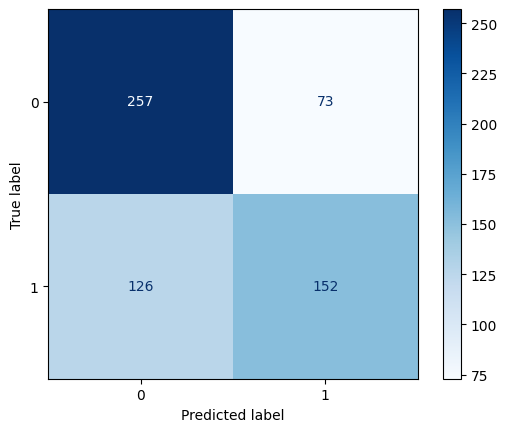

In [12]:
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [13]:
#Create list for cat features
cat_features = list(range(0, X.shape[1]))
# print(cat_features)

#Create feature importance
featurep = catboost_model.get_feature_importance(prettified=True)
featurep

,Feature Id,Importances
0,ewm_possession_home_binned,4.427512
1,ewm_away_team_goals,4.324983
2,ewm_shoton_home,4.205284
3,ewm_shoton_away,4.014573
4,defensive_weakness_diff,3.835582
5,ewm_home_team_goals,3.796163
6,away_streak_wins,3.755189
7,ewm_possession_away,3.195284
8,player_rating_away_player_7,2.990343
9,player_rating_away_player_8,2.970255


In [14]:
from shap import TreeExplainer

shap_explainer = TreeExplainer(catboost_model)
shap_values = shap_explainer.shap_values(X_train)

In [15]:
preds_train, shaps_train, shap_expected_value_train = get_preds_shaps(X_train, X_val, y_train, y_val, True)
preds_val, shaps_val, shap_expected_value_val = get_preds_shaps(X_train, X_val, y_train, y_val, False)

In [16]:
assert ((preds_train - (shap_expected_value_train + shaps_train.sum(axis=1)).apply(shap_sum2proba)).abs() < 1e-10).all()
assert ((preds_val - (shap_expected_value_val + shaps_val.sum(axis=1)).apply(shap_sum2proba)).abs() < 1e-10).all()

In [17]:
prediction_contribution_trn, error_contribution_trn = get_feature_contributions(
  y_true=y_train, 
  y_pred=preds_train, 
  shap_values=shaps_train,
  shap_expected_value=shap_expected_value_train
)

prediction_contribution_val, error_contribution_val = get_feature_contributions(
  y_true=y_val, 
  y_pred=preds_val, 
  shap_values=shaps_val,
  shap_expected_value=shap_expected_value_val
)

contributions_trn = pd.concat([prediction_contribution_trn, error_contribution_trn], axis=1)
contributions_val = pd.concat([prediction_contribution_val, error_contribution_val], axis=1)

In [18]:
contributions_trn.to_csv("contributions_trn.csv", index=True)
contributions_val.to_csv("contributions_val.csv", index=True)

In [19]:
contributions_trn = pd.read_csv("contributions_trn.csv", index_col=0)
contributions_val = pd.read_csv("contributions_val.csv", index_col=0)

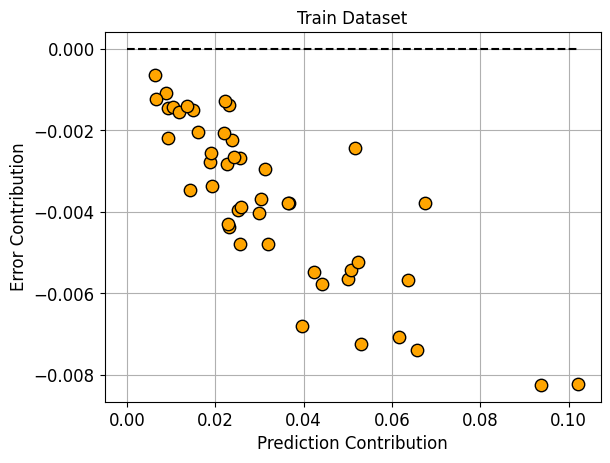

In [20]:
fig, ax = plt.subplots()

ax.scatter(contributions_trn["prediction_contribution"], contributions_trn["error_contribution"], s=80, color="orange", edgecolors="black")
ax.hlines(y=0, xmin=0, xmax=contributions_trn["prediction_contribution"].max(), ls="--", color="black")
ax.tick_params(axis="both", which="major", labelsize=12)
ax.grid(); ax.set_axisbelow(True)
ax.set_title("Train Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

fig.savefig("single_trn.png", dpi=200, bbox_inches="tight")

In [21]:
pd.set_option("display.max_rows", 10)
contributions_trn.sort_values("prediction_contribution", ascending=False).head(10)

,prediction_contribution,error_contribution
ewm_shoton_away,0.102096,-0.008226
ewm_shoton_home,0.093728,-0.008248
avg_home_team_rating,0.067351,-0.003775
defensive_weakness_diff,0.065584,-0.007386
player_rating_away_player_8,0.063680,-0.005683
away_streak_wins,0.061610,-0.007082
ewm_away_team_goals,0.052962,-0.007253
ewm_possession_home_x_ewm_shoton_home,0.052216,-0.005237
num_top_players_home,0.051703,-0.002440
home_streak_wins,0.050609,-0.005435


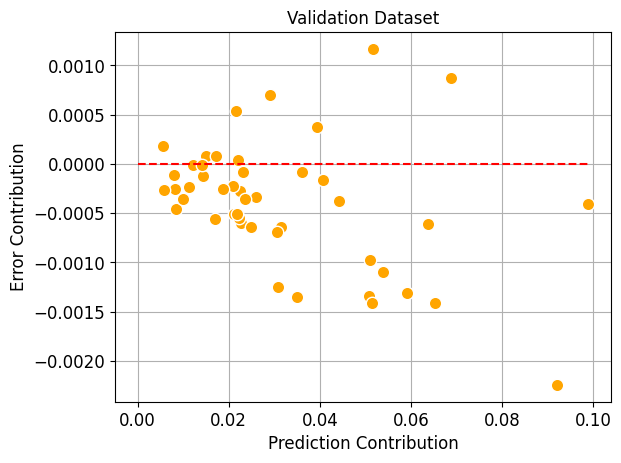

In [22]:
fig, ax = plt.subplots()

ax.scatter(contributions_val["prediction_contribution"], contributions_val["error_contribution"], s=80, color="orange", edgecolors="white")
ax.hlines(y=0, xmin=0, xmax=contributions_val["prediction_contribution"].max(), ls="--", color="red")
ax.tick_params(axis="both", which="major", labelsize=12)

ax.grid()
ax.set_axisbelow(True)
ax.set_title("Validation Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

fig.savefig("single_val.png", dpi=200, bbox_inches="tight")

In [23]:
pd.set_option("display.max_rows", 10)

contributions_val.sort_values("error_contribution", ascending=True).round(4).head(10)

,prediction_contribution,error_contribution
ewm_shoton_home,0.0921,-0.0022
ewm_possession_home_x_ewm_shoton_home,0.0515,-0.0014
avg_home_team_rating,0.0652,-0.0014
player_rating_home_player_9,0.0350,-0.0014
home_streak_wins,0.0508,-0.0013
away_streak_wins,0.0591,-0.0013
player_rating_home_player_8,0.0308,-0.0013
num_top_players_home,0.0538,-0.0011
ewm_away_team_goals,0.0511,-0.0010
avg_away_team_rating_binned,0.0307,-0.0007


In [24]:
pd.set_option("display.max_rows", 10)

contributions_val.sort_values("prediction_contribution", ascending=False).round(4).head(10)

,prediction_contribution,error_contribution
ewm_shoton_away,0.0990,-0.0004
ewm_shoton_home,0.0921,-0.0022
defensive_weakness_diff,0.0688,0.0009
avg_home_team_rating,0.0652,-0.0014
player_rating_away_player_8,0.0638,-0.0006
away_streak_wins,0.0591,-0.0013
num_top_players_home,0.0538,-0.0011
player_rating_away_player_7,0.0517,0.0012
ewm_possession_home_x_ewm_shoton_home,0.0515,-0.0014
ewm_away_team_goals,0.0511,-0.0010


In [35]:
from tqdm import tqdm
from sklearn.metrics import log_loss, average_precision_score


features= X_train.columns.to_list()
rfe_error = pd.DataFrame(dtype=float)
features_curr = features.copy()
feature_drop = None

for iteration in tqdm(range(len(features))):
    preds_val, shaps_val, shap_expected_value_val = get_preds_shaps(X_train[features_curr], X_val[features_curr], y_train, y_val, False)
    
    prediction_contribution_val, error_contribution_val = get_feature_contributions(
        y_true=y_val, 
        y_pred=preds_val, 
        shap_values=shaps_val,
        shap_expected_value=shap_expected_value_val
    )  
    
    rfe_error.loc[iteration, "feature_drop"] = feature_drop
    rfe_error.loc[iteration, "n_features"] = len(features_curr)
    rfe_error.loc[iteration, "contrib"] = error_contribution_val.max()
    
    rfe_error.loc[iteration, "logloss_trn"] = log_loss(y_train['result_match'], preds_train)
    rfe_error.loc[iteration, "logloss_val"] = log_loss(y_val['result_match'], preds_val)
    # rfe_error.loc[iteration, "logloss_tst"] = log_loss(df.loc[ix_tst, target], preds.loc[ix_tst])
    
    rfe_error.loc[iteration, "ap_trn"] = average_precision_score(y_train['result_match'], preds_train, average='weighted')
    rfe_error.loc[iteration, "ap_val"] = average_precision_score(y_val['result_match'], preds_val, average='weighted')
    # rfe_error.loc[iteration, "ap_tst"] = average_precision_score(df.loc[ix_tst, target], preds.loc[ix_tst])
    
    rfe_error.loc[iteration, "f1_trn"] = f1_score(y_train['result_match'], preds_train, average='binary', pos_label='binary')
    rfe_error.loc[iteration, "f1_val"] = f1_score(y_val['result_match'], preds_val, average='binary', pos_label='binary')
    # rfe_error.loc[iteration, "f1_tst"] = f1_score(df.loc[ix_tst, target], preds.loc[ix_tst])

    feature_drop = error_contribution_val.idxmax()
    
    
    features_curr.remove(feature_drop)

  0%|          | 0/46 [00:17<?, ?it/s]


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
features= X_train.columns.to_list()
rfe_prediction = pd.DataFrame(dtype=float)
features_curr = features.copy()
feature_drop = None

for iteration in tqdm(range(len(features))):
    preds_val, shaps_val, shap_expected_value_val = get_preds_shaps(X_train[features_curr], X_val[features_curr], y_train, y_val, False)
    
    prediction_contribution_val, error_contribution_val = get_feature_contributions(
        y_true=y_val, 
        y_pred=preds_val, 
        shap_values=shaps_val,
        shap_expected_value=shap_expected_value_val
    )   
    
    rfe_prediction.loc[iteration, "feature_drop"] = feature_drop
    rfe_prediction.loc[iteration, "n_features"] = len(features_curr)
    rfe_prediction.loc[iteration, "contrib"] = prediction_contribution_val.max()
    
    rfe_prediction.loc[iteration, "logloss_trn"] = log_loss(y_train['result_match'], preds_train)
    rfe_prediction.loc[iteration, "logloss_val"] = log_loss(y_val['result_match'], preds_val)
    # rfe_prediction.loc[iteration, "logloss_tst"] = log_loss(df.loc[ix_tst, target], preds.loc[ix_tst])
    rfe_prediction.loc[iteration, "ap_trn"] = average_precision_score(y_train['result_match'], preds_train)
    rfe_prediction.loc[iteration, "ap_val"] = average_precision_score(y_val['result_match'], preds_val)
    # rfe_prediction.loc[iteration, "ap_tst"] = average_precision_score(df.loc[ix_tst, target], preds.loc[ix_tst])
    
    rfe_prediction.loc[iteration, "f1_trn"] = f1_score(y_train['result_match'], preds_train, average='weighted'))
    rfe_prediction.loc[iteration, "f1_val"] = f1_score(y_val['result_match'], preds_val, average='weighted'))
    # rfe_prediction.loc[iteration, "f1_tst"] = f1_score(df.loc[ix_tst, target], preds.loc[ix_tst])

    feature_drop = prediction_contribution_val.idxmax()
    
    features_curr.remove(feature_drop)

In [ ]:
rfe_error.to_csv("home_win_rfe_error.csv", index=False)
rfe_prediction.to_csv("home_not_win_rfe_prediction.csv", index=False)

In [ ]:
rfe_error = pd.read_csv("home_win_rfe_error.csv")
rfe_prediction = pd.read_csv("home_not_win_rfe_prediction.csv")

In [ ]:
max_iter_show = len(features) - 3

In [ ]:
fig, ax = plt.subplots()

idxmin_prediction = rfe_prediction["logloss_val"].idxmin()
idxmin_error = rfe_error["logloss_val"].idxmin()

ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["logloss_val"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["logloss_val"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.scatter(-rfe_prediction.loc[idxmin_prediction,"n_features"], rfe_prediction.loc[idxmin_prediction,"logloss_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.scatter(-rfe_error.loc[idxmin_error,"n_features"], rfe_error.loc[idxmin_error,"logloss_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.set_title("Validation Set", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("rfe_logloss_val_.png", dpi=200, bbox_inches="tight")

In [ ]:
rfe_error.sort_values("logloss_val", ascending=True).head(4)

In [ ]:
rfe_prediction.sort_values("logloss_val", ascending=True).head(4)

In [ ]:
fig, ax = plt.subplots()

idxmax_prediction = rfe_prediction["ap_val"].idxmax()
idxmax_error = rfe_error["ap_val"].idxmax()

ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["ap_val"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["ap_val"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.scatter(-rfe_prediction.loc[idxmax_prediction,"n_features"], rfe_prediction.loc[idxmax_prediction,"ap_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.scatter(-rfe_error.loc[idxmax_error,"n_features"], rfe_error.loc[idxmax_error,"ap_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.set_title("Test Set", fontsize=12)
ax.set_ylabel("Average Precision", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("rfe_ap_tst_.png", dpi=200, bbox_inches="tight")

In [ ]:
rfe_error